In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
import sys
sys.path.append("../utility")
sys.path.append("../train")
from Utility import DerivativeLiftFunc, data_collecter,RBFLiftFunc
import lqr
import time

/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]

In [3]:
method_index = 0
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
suffix = "DampingPendulum1_26"
env_name = "DampingPendulum"
# suffix = "MountainCarContinuous1_26"
# env_name = "MountainCarContinuous-v0"

In [4]:
Kd = np.load("Prediction_Results/"+"Kd_"+env_name+"_KoopmanDerivative"+".npy")
Data_collecter = data_collecter(env_name)
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
LiftFunc = DerivativeLiftFunc(env_name,Nstate,udim)
NKoopman = LiftFunc.NKoopman
eig = np.linalg.eigvals(Kd)
print("max eig val:{}".format(max(eig)))
# print(Kd)

max eig val:(0.9999999999999998+0j)


In [5]:
def Prepare_Region_LQR(env_name,precision = 0.1):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = np.eye(1)
        theta_region = np.arange(-2.0,2.0,precision)
        dtheta_region = np.arange(-2.0,2.0,precision)
        reset_state_list = []
        for theta in theta_region:
            for dtheta in dtheta_region:
                reset_state_list.append([0.0,0.0,theta,dtheta])
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = np.eye(1)
        theta = np.arange(-6.0,6.0,precision)
        dtheta = np.arange(-6.0,6.0,precision)
        thetaR,dthetaR = np.meshgrid(theta,dtheta)
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = np.eye(1)
        theta_region = np.arange(-4.0,4.0,precision)
        dtheta_region = np.arange(-4.0,4.0,precision)
        reset_state_list = []
        for theta in theta_region:
            for dtheta in dtheta_region:
                reset_state_list.append([theta,dtheta])
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.1
        R = np.eye(1)
        x_region = np.arange(-1.2,0.6,precision)
        dx_region = np.arange(-1.0,1.0,precision)
        reset_state_list = []
        for x in x_region:
            for dx in dx_region:
                reset_state_list.append([x,dx])
        x_ref[0] = 0.45
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state_list,x_ref

In [6]:
def Done(env_name,state):
    if env_name.startswith("CartPole"):
        done = (abs(state[2]) >= np.pi)
    if env_name.startswith("Pendulum"):
        done = (abs(state[0]) >= 2*np.pi)
    if env_name.startswith("DampingPendulum"):
        done = (abs(state[0]) >= 2*np.pi)
    if env_name.startswith("MountainCarContinuous"):
        done = (state[0]>0.7 or state[0]<-1.3)
    return done 

def exp(env,env_name,Ad,Bd,Q,R,reset_state,x_ref):
    Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
    observation_list = []
    observation = np.array(env.reset_state(reset_state))
    x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
    x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(NKoopman,1)
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list = []
    steps = 200
    flag = False
    for i in range(steps):
        u = -Kopt*(x0-x_ref_lift)
        observation, reward, done, info = env.step(u[0,0])
        done = Done(env_name,observation)
        if done:
            flag = True
            break
        x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
        observation_list.append(x0[:Nstate].reshape(-1,1))
        u_list.append(u)
    u_list = np.array(u_list).reshape(-1)
    observations = np.concatenate(observation_list,axis=1)
    return observations,u_list,flag

def criterion(env_name,observations,flag):
    if flag:
        return 0
    elif env_name.startswith("CartPole"):
        err = np.mean(abs(observations[2:,195:]))
        good = int(err <= 1e-2)
    elif env_name.startswith("Pendulum"):
        err = np.mean(abs(observations[:,195:]))
        good = int(err <= 1e-2)        
    elif env_name.startswith("DampingPendulum"):
        err = np.mean(abs(observations[:,195:]))
        good = int(err <= 1e-2)    
    elif env_name.startswith("MountainCarContinuous"):
        err = np.mean(abs(observations[0,195:]-0.45))+np.mean(abs(observations[1,195:]))
        good = int(err <= 1e-2)      
    return good

def Err(env_name,observations,flag):
    if flag:
        return None
    elif env_name.startswith("CartPole"):
        err = np.mean(abs(observations[2:,195:]))
    elif env_name.startswith("Pendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("DampingPendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("MountainCarContinuous"):
        err = np.mean(abs(observations[0,195:]-0.45))+np.mean(abs(observations[1,195:]))
    return err

def Cost(observations,u_list,Q,R,x_ref):
    steps = observations.shape[1]
    loss = 0
    for s in range(steps):
        if s!=steps-1:
            ucost = np.dot(np.dot(u_list[s].T,R),u_list[s])
            loss += ucost[0,0]
        xcost = np.dot(np.dot((observations[:,s]-x_ref).T,Q),(observations[:,s]-x_ref))
        loss += xcost[0,0]
    return loss

In [8]:
Ad = Kd[:NKoopman,:NKoopman]
Bd = Kd[:NKoopman,NKoopman:]
env = Data_collecter.env
env.reset()
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
precision = 0.1
Q,R,reset_state_list,x_ref = Prepare_Region_LQR(env_name,precision=precision)
for u_val in [0.01,0.1,1,2,5,10,20,50,100]:
    Errs = {}
    Costs = {}
    for reset_state in reset_state_list:
        obs,u_list,flag = exp(env,env_name,Ad,Bd,Q,u_val*R,reset_state,x_ref)
        err = Err(env_name,obs,flag)
        Errs[(reset_state[-2],reset_state[-1])] = err
        if flag:
            Costs[(reset_state[-2],reset_state[-1])] = None
        else:
            cost = Cost(obs,u_list,Q[:Nstate,:Nstate],0.0*R,x_ref)
            Costs[(reset_state[-2],reset_state[-1])] = cost
    np.savez("ControlResults2_2/"+env_name+"_KoopmanDerivative_uval{}.npz".format(u_val),err=Errs,cost=Costs)
    print("Uval:{} OK!".format(u_val))

Uval:0.01 OK!


KeyboardInterrupt: 

In [67]:
Ad = Kd[:NKoopman,:NKoopman]
Bd = Kd[:NKoopman,NKoopman:]
env = Data_collecter.env
env.reset()
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Results = {}
precision = 0.1
Q,R,reset_state_list,x_ref = Prepare_Region_LQR(env_name,precision=precision)
for reset_state in reset_state_list:
    for u_val in [0.001,0.01,0.1,1,2,5,10,20,50,100]:
        obs,flag = exp(env,env_name,Ad,Bd,Q,u_val*R,reset_state,x_ref)
        result = criterion(env_name,obs,flag)
        Results[(reset_state[-2],reset_state[-1])] = result
        if result:
            break

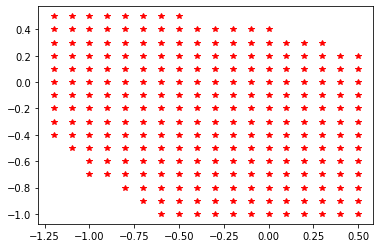

In [68]:
points = []
for key in Results:
    if Results[key]:
        points.append(np.array([key[0],key[1]]))
points = np.array(points).reshape(-1,2)
plt.plot(points[:,0],points[:,1],'r*')
plt.savefig("ControlResults/"+env_name+"_KoopmanDerivative_saferegion.png")
plt.show()
# print(points.shape)
np.save("ControlResults/"+env_name+"_KoopmanDerivative_saferegion.npy",points)

In [96]:
def Prepare_Single_LQR(env_name):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = 0.001*np.eye(1)
        reset_state=  [0.0,0.0,-0.5,2.0]
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.01*np.eye(1)
        reset_state = [-0.5,0.1]
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.01*np.eye(1)
        reset_state = [-2.5,0.1]   
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.1
        R = 0.001*np.eye(1)
        reset_state = [0.46,0.0]  
        x_ref[0] = 0.45
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref

0.0044869691676770644


/home/stone/Documents/Koopman/gym/gym/envs/classic_control/cartpole.py:156: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


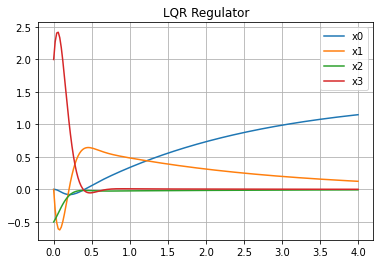

In [97]:
Ad = Kd[:NKoopman,:NKoopman]
Bd = Kd[:NKoopman,NKoopman:]
env = Data_collecter.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
observation_list = []
observation = np.array(env.reset_state(reset_state))
x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(NKoopman,1)
observation_list.append(x0[:Nstate].reshape(-1,1))
# print(Kopt)
u_list = []
steps = 200
# umax = 100
for i in range(steps):
    # env.render()
    u = -Kopt*(x0-x_ref_lift)
    # u = max(-umax,min(umax,u[0,0]))
    # print(type(u[0,0]),type(u))
    # print(u[0,0])
    observation, reward, done, info = env.step(u[0,0])
    x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
    # x0 = Ad*x0+Bd*u
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list.append(u)
    # time.sleep(0.1)
# print(observation_list)
observations = np.concatenate(observation_list,axis=1)
print(np.mean(abs(observations[2:,195:])))
u_list = np.array(u_list).reshape(-1)
time_history = np.arange(steps+1)*env.dt
for i in range(Nstate):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.show()